In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid")

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://destinationpaschere.com/wp-content/uploads/2017/11/Berlin.jpg")

__Objective__: The goal of this notebook is to get insight in room pricing of Berlin. We will identify by visualizing the differences in areas and pricing. 

Moreover, We will try to predict a room price by the given location, number of rooms and squaremeters. This way people that would like to rent out a room can have an estimate of what to ask.

In [3]:
# load in the data from sqlite db
query = """SELECT * FROM rooms;"""
db = sqlite3.connect('/Users/joppevos/PycharmProjects/zimmer-scraper/ebayrooms.db')
data = pd.read_sql_query(query,db)

In [4]:
data.head()

,price,location,rooms,square,ID
0,490,Reinickendorf,1.0,20.0,-9119609883814179586
1,420,Steglitz,3.0,95.0,-9063653813727574929
2,500,Kreuzberg,2.0,35.0,-9034391333316471009
3,470,Tiergarten,1.0,39.0,-8930474152331035757
4,300,Pankow,1.0,15.0,-8901689635451880751


In [5]:
# missing data in columns 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 5 columns):
price       1888 non-null int64
location    1888 non-null object
rooms       1857 non-null float64
square      1860 non-null float64
ID          1888 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 73.8+ KB


In [6]:
# replace the missing values with the most frequent value 
data['square'] = data['square'].fillna(data['square'].mode()[0])
data['rooms'] = data['rooms'].fillna(data['rooms'].mode()[0])

In [7]:
# the ID column was to make sure there are no duplicates in the scraped rooms. we drop it
data.drop(columns='ID', inplace=True)

In [8]:
# check the dtypes in each column
data.dtypes

price         int64
location     object
rooms       float64
square      float64
dtype: object

In [9]:
# int dtype is all we need since half rooms are hard to work with. Converting dtypes to int will round the numbers
data['rooms'] = data['rooms'].astype(int)
data['square'] = data['square'].astype(int)

In [10]:
# check the number of datapoints we got for each location
trace = go.Histogram(x=data['location'])
iplot([trace])

By plotting a histogram we recieve some valuable insight from the data. Most of the available rooms are in Neukolln. 
We can clearly see some locations have almost no inputs. We have the area 'Rudow' with only 1 input. We will drop locations since an average will be not representable and prone to errors later on.

In [11]:
# Drop locations with less than 30 inputs
value_counts = data['location'].value_counts()  
removed = value_counts[value_counts <= 30].index
data.replace(removed, np.nan, inplace=True)
data.dropna(inplace=True)

Text(0.5, 0, 'price')

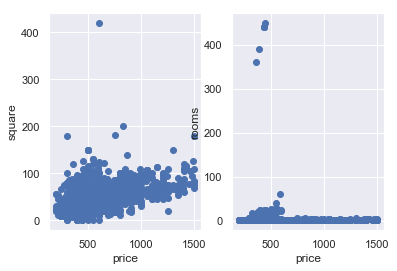

In [12]:
# visualize screwness
plt.subplot(1, 2, 1)
plt.scatter(x=data['price'], y=data['square']);
plt.ylabel('square')
plt.xlabel('price')

plt.subplot(1, 2, 2)
plt.scatter(x=data['price'], y=data['rooms']);
plt.ylabel('rooms')
plt.xlabel('price')

We can clearly see there are some extreme outliers. After checking some outliers on ebay I noticed that some people tend to give the wrong information about the number of rooms and size. They dont give the size of the room, but of  the complete appartment building. Above a 150 m2, we are not sure if the information is true. 

The same for the number of rooms. Most of the data is distributed below 5 rooms with some outliers of 500 rooms!

In [13]:
# we drop the size above 100m2 or less than 5m2
data.drop(data[data['square'] > 150].index, inplace=True)
data.drop(data[data['square'] < 5].index, inplace=True)

In [14]:
# 450 rooms for 1410 euro sounds a bit too good
data.loc[data.rooms > 4].max()

price              1410
location    Wilmersdorf
rooms               450
square              150
dtype: object

In [15]:
# we drop the rows with rooms above 5
data.drop(data[data['rooms'] > 4].index, inplace=True);


In [16]:
# plot the adjusted data
trace2 = go.Scatter(x=data['price'], y=data['square'], mode='markers')
layout = go.Layout(title = 'Avaible rooms in Berlin',
                  xaxis = dict(
                      title = "Price of the room"),
                       
                   yaxis = dict(
                      title = 'Square meters'))
                   
xdata = [trace2]
fig = go.Figure(data=xdata, layout=layout)
iplot(fig, filename='axes-booleans')

The outliers are removed and now you see got a clear distribution in our plot. Most of the avaible rooms are clustered around the 400 euro for less than 20 square meters.
Lets visualise the data some more and see if we can find some patterns.

In [17]:
# here we see all the mean prices for each area.
table = pd.pivot_table(data=data, index=data['location'], columns=['rooms'], values='price')
table = table.sort_values(by=[1,2,3,4], ascending=False).round()
table[:5]

rooms,1,2,3,4
location,,,,
Steglitz,533.0,763.0,721.0,1148.0
Wilmersdorf,520.0,717.0,821.0,1474.0
Charlottenburg,517.0,819.0,962.0,1235.0
Mitte,506.0,782.0,853.0,720.0
PrenzlauerBerg,503.0,910.0,834.0,700.0


The average cost of a room can be found in the pivot_table above. Interesting is to see that in some areas going from 3 to 4 lowers the price. One of my Berliner room-mates told me that some of the older houses have 4 rooms. Where the the newer renovated houses demolished the walls to make bigger living areas.

But the above information is only the average price for a room. We complety miss out here on how much square meters you get for that price. Lets see if 'Steglitz' is still the highest if we check price per square meter.

In [18]:
# An import feature to add to would be the price per square meter. 
data['price_m2'] = data['price']/data['square']

In [19]:
table = pd.pivot_table(data=data, index=data['location'], columns=['rooms'], values='price_m2')
table = table.sort_values(by=[1,2,3,4], ascending=False).round(2)
table[:5]

rooms,1,2,3,4
location,,,,
Weissensee,25.85,12.33,9.35,9.26
Charlottenburg,25.31,14.22,12.82,13.28
Köpenick,24.37,12.86,10.17,11.25
Mitte,24.34,13.92,10.39,6.17
Pankow,23.08,12.25,9.97,9.45


Weissensee comes out highest price per square meter. Steglitz is not even in the top 5 anymore.

In [20]:
trace = go.Bar(y=table[1], x=table.index)
layout = go.Layout(title = 'Price per m2 for 1 room',
                   width=700,
                   height=500,
                   autosize = False,
                  xaxis = dict(
                      title = "Location"),
                   yaxis = dict(
                       range=[10, 26],
                      title = 'price m2'))

fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='axes-booleans')


As a student I live in 'Wedding' at the moment. In the barplot above you can clearly see why. It is the least expensive place to rent.

### Prediction
Now that the data is clean. we would like to predict a price for a room if you place it on ebay. A guideline to show customers what the current market values the property at. 

In [21]:
# split the indepented variable from the data 
X = data.drop(labels='price', axis=1)
y = data['price']

In [22]:
# Generate dummies for the categorical locations
X= pd.get_dummies(data=X, columns=['location'])

In [23]:
# split the train and target data 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [24]:
m = RandomForestRegressor()

We will be using RandomForestRegressor for this set. For a regression tree, the random forest model takes an average of all the individual decision tree estimates. 

In [25]:
m.fit(xtrain, ytrain);
ypred = m.predict(xtest)
r2_score(ytest, ypred)

0.9847008837022116

The dataset is not massive and by splitting it we lose already a big portion. For an second opinion we will validate on the whole dataset by cross-validating.

In [48]:
from sklearn.model_selection import cross_val_score
m = RandomForestRegressor(n_estimators=100)
cross_val_score(m, X, y, cv=10).mean()


0.9876066696021057

A RSMA of 98% of the model to predict the pricing for a room.

We can find out what the most important features are that predict a room price. 
RandomForest gives us an array of feature_importances that is calculated by shuffling each feature individual and returns the loss difference in R2.


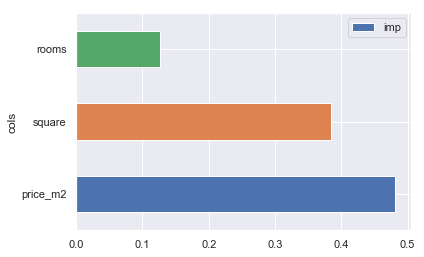

In [41]:
m.fit(xtrain, ytrain)
fi = pd.DataFrame({'cols':X.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)[:3]
fi.plot('cols', 'imp', kind='barh');

As expected is the most important feature price_m2.

### Final thoughts
-  The prices in Berlin are higher than expected. A lot of students in my envoriment underestimated the current price of rooms. Part of it comes to that Berlin at the moment is having the fastest ricing property prices in the world. So prices you year from people that have lived here or you find online, are probably outdated by quite some percentages.
- Next time I would scrape more features. These features will be for sure the most weighted in price prediction, but do not give interesting insight like for example "Number of flatmates".